In [11]:
import os
import sys
import json
import h5py
import glob
import numpy as np
import tensorflow as tf
import functools
import pdb

%matplotlib inline
import matplotlib.pyplot as plt

import pitchnet_evaluate_best

sys.path.append('ibmHearingAid/multi_gpu')
import functions_brain_network
import functions_graph_assembly as fga

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_figures_cnn
import util_stimuli
import util_misc


In [2]:
fn_brain_arch = '/saved_models/arch_search_v02_topN/f0_label_192/arch_0302/brain_arch.json'
with open(fn_brain_arch, 'r') as f:
    list_brain_arch = json.load(f)


In [3]:
tf.reset_default_graph()

input_shape = [1, 100, 1000, 1]
input_tensor = tf.placeholder(tf.float32, shape=input_shape, name='input_tensor')
output_tensor, nets = functions_brain_network.make_brain_net(
    input_tensor,
    {'f0_label': 700},
    list_brain_arch)


Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
tf.reset_default_graph()

input_shape = [1, 1, 4800, 1]
input_tensor = tf.placeholder(tf.float32, shape=input_shape, name='input_tensor')

list_brain_arch_tmp = [
    {
        'args': {
            'name': 'coch_slice_0',
            'begin': [0, 0, 2160, 0],
            'size': [-1, -1, 2400, -1],
        },
        'layer_type': 'tf.slice'
    },
    {
        'args': {
            'activation': None,
            'dilation_rate': [1, 1],
            'filters': 100,
            'kernel_size': [1, 801],
            'name': 'coch_conv_0',
            'padding': 'VALID',
            'strides': [1, 1]
        },
        'layer_type': 'tf.layers.conv2d'
    },
    {
        'args': {
            'name': 'coch_transpose_0',
            'perm': [0, 3, 2, 1]
        },
        'layer_type': 'tf.transpose'
    },
    {
        "args": {
            "name": "coch_relu_0"
        },
        "layer_type": "tf.nn.relu"
    },
    {
        "args": {
            "name": "coch_tfnnresample_0",
            "sr_input": 32e3,
            "sr_output": 20e3,
            "kwargs_nnresample_poly_filter": {
                "down": 4,
                "up": 1
            },
        },
        "layer_type": "tfnnresample"
    },
    {
        "args": {
            "name": "coch_relu_1"
        },
        "layer_type": "tf.nn.relu"
    },
]

# list_brain_arch_tmp = list_brain_arch_tmp + list_brain_arch

import importlib
importlib.reload(functions_brain_network)

output_tensor, nets = functions_brain_network.make_brain_net(
    input_tensor,
    {'f0_label': 700},
    list_brain_arch_tmp)

output_tensor, nets


[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=1 rather than up=5 for nnresample_poly_filter
[tfnnresample] using down=4 rather than down=8 for nnresample_poly_filter
[tfnnresample] using window_length=8000 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 4000.0 Hz for anti-aliasing lowpass filter


(<tf.Tensor 'coch_relu_1:0' shape=(1, 100, 1000, 1) dtype=float32>,
 {'coch_conv_0': <tf.Tensor 'coch_conv_0/BiasAdd:0' shape=(1, 1, 1600, 100) dtype=float32>,
  'coch_relu_0': <tf.Tensor 'coch_relu_0:0' shape=(1, 100, 1600, 1) dtype=float32>,
  'coch_relu_1': <tf.Tensor 'coch_relu_1:0' shape=(1, 100, 1000, 1) dtype=float32>,
  'coch_slice_0': <tf.Tensor 'coch_slice_0:0' shape=(1, 1, 2400, 1) dtype=float32>,
  'coch_tfnnresample_0': <tf.Tensor 'Conv2D:0' shape=(1, 100, 1000, 1) dtype=float32>,
  'coch_transpose_0': <tf.Tensor 'coch_transpose_0:0' shape=(1, 100, 1600, 1) dtype=float32>})

In [21]:
regex_fn = '/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/PND_*.hdf5'
list_fn = glob.glob(regex_fn)
fn = list_fn[0]
# for k in util_misc.get_hdf5_dataset_key_list(fn):
#     print(k)

with h5py.File(fn, 'r') as f:
    IDX = -50
    idx0 = f['nopad_start_index'][IDX] - f['segment_start_index'][IDX]
    idx1 = f['nopad_end_index'][IDX] - f['segment_end_index'][IDX]
    
    print(f['f0'][IDX], f['nopad_f0_mean'][IDX])
    print(f['stimuli/signal_in_noise'][IDX, idx0:idx1].shape[0] / f['sr'][0])
    print(idx0, idx1)
    
    print(f['stimuli/signal_in_noise_dBSPL'][IDX])


80.4471 80.4471
0.07
2240 -320
50.397247


In [37]:
list_fn =[
    '/om/user/msaddler/data_pitchnet/bernox2005/lowharm_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/mooremoore2003/freqshifted_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/moore1985/mistunedharm_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/oxenham2004/transposedtones_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/shackcarl1994/altphase_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/bernox2005/exact_v00/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/bernox2005/exact_v01/stim.hdf5',
]
for fn in list_fn:
    list_k = util_misc.get_hdf5_dataset_key_list(fn)
    fn_new = fn.replace('.hdf5', '_waveform.hdf5')
    with h5py.File(fn, 'r') as f:
        print('###', fn)
        print('###', fn_new)
        list_candidate_signal_k = [k for k in list_k if f[k].shape[-1] == 4800]
        list_other_k = [k for k in list_k if not f[k].shape[-1] == 4800]
        if len(list_candidate_signal_k) > 1:
            list_candidate_signal_k = [k for k in list_candidate_signal_k if 'noise' in k]
        assert len(list_candidate_signal_k) == 1
        
        assert not fn_new == fn
#         with h5py.File(fn_new, 'w') as f_new:
#             for k in list_other_k:
#                 f_new.create_dataset(k, data=f[k][:])
#             f_new.create_dataset('stimuli/signal_in_noise', data=f[list_candidate_signal_k[0]][:])
#             print(f_new['stimuli/signal_in_noise'])


### /om/user/msaddler/data_pitchnet/bernox2005/lowharm_v01/stim.hdf5
### /om/user/msaddler/data_pitchnet/bernox2005/lowharm_v01/stim_waveform.hdf5
<HDF5 dataset "signal_in_noise": shape (72600, 4800), type "<f4">
### /om/user/msaddler/data_pitchnet/mooremoore2003/freqshifted_v01/stim.hdf5
### /om/user/msaddler/data_pitchnet/mooremoore2003/freqshifted_v01/stim_waveform.hdf5
<HDF5 dataset "signal_in_noise": shape (83391, 4800), type "<f4">
### /om/user/msaddler/data_pitchnet/moore1985/mistunedharm_v01/stim.hdf5
### /om/user/msaddler/data_pitchnet/moore1985/mistunedharm_v01/stim_waveform.hdf5
<HDF5 dataset "signal_in_noise": shape (83304, 4800), type "<f4">
### /om/user/msaddler/data_pitchnet/oxenham2004/transposedtones_v01/stim.hdf5
### /om/user/msaddler/data_pitchnet/oxenham2004/transposedtones_v01/stim_waveform.hdf5
<HDF5 dataset "signal_in_noise": shape (24576, 4800), type "<f4">
### /om/user/msaddler/data_pitchnet/shackcarl1994/altphase_v01/stim.hdf5
### /om/user/msaddler/data_pitchn

In [5]:
import os
import sys
import json
import glob
import copy
import collections
import re
import numpy as np
import importlib

sys.path.append('/code_location/multi_gpu')
import functions_parameter_handling
importlib.reload(functions_parameter_handling)

list_brain_arch_prepend = [
    {
        'args': {
            'name': 'coch_slice_0',
            'begin': [0, 0, 2160, 0],
            'size': [-1, -1, 2400, -1],
        },
        'layer_type': 'tf.slice'
    },
    {
        'args': {
            'activation': None,
            'dilation_rate': [1, 1],
            'filters': 100,
            'kernel_size': [1, 801],
            'name': 'coch_conv_0',
            'padding': 'VALID',
            'strides': [1, 1]
        },
        'layer_type': 'tf.layers.conv2d'
    },
    {
        'args': {
            'name': 'coch_transpose_0',
            'perm': [0, 3, 2, 1]
        },
        'layer_type': 'tf.transpose'
    },
    {
        "args": {
            "name": "coch_relu_0"
        },
        "layer_type": "tf.nn.relu"
    },
    {
        "args": {
            "name": "coch_tfnnresample_0",
            "sr_input": 32e3,
            "sr_output": 20e3,
            "kwargs_nnresample_poly_filter": {
                "down": 8,
                "up": 5,
                "window_length": 161
            },
        },
        "layer_type": "tfnnresample"
    },
    {
        "args": {
            "name": "coch_relu_1"
        },
        "layer_type": "tf.nn.relu"
    },
]


regex_src_dir = '/saved_models/arch_search_v02_topN/TEMPLATE/arch_0???'
list_src_dir = glob.glob(regex_src_dir)

for src_dir in list_src_dir:
    dst_dir = src_dir.replace('TEMPLATE', 'cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10')
    fn_src_config = os.path.join(src_dir, 'config.json')
    fn_src_arch = os.path.join(src_dir, 'brain_arch.json')
    fn_dst_config = os.path.join(dst_dir, 'config.json')
    fn_dst_arch = os.path.join(dst_dir, 'brain_arch.json')
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)
    
    with open(fn_src_config, 'r') as f:
        CONFIG = json.load(f)
    
    CONFIG['signal_rate'] = 32e3
    CONFIG['BRAIN_PARAMS'].pop('save_pckl_path')
    CONFIG['ITERATOR_PARAMS']['feature_parsing_dict'].pop('nervegram_meanrates')
    CONFIG['ITERATOR_PARAMS']['feature_parsing_dict']['stimuli/signal_in_noise'] = {
        "dtype": "tf.float32",
        "shape": [4800]
    }
    CONFIG['ITERATOR_PARAMS']['feature_signal_path'] = 'stimuli/signal_in_noise'
    with open(fn_dst_config, 'w') as f:
        json.dump(CONFIG, f, indent=4, sort_keys=True)
    
    functions_parameter_handling.migrate_config_to_new_output_directory(
        fn_dst_config,
        dst_dir,
        force_overwrite=True)
    
    with open(fn_src_arch, 'r') as f:
        BRAIN_ARCH = json.load(f)
    
    BRAIN_ARCH = list_brain_arch_prepend + BRAIN_ARCH
    with open(fn_dst_arch, 'w') as f:
        json.dump(BRAIN_ARCH, f, indent=4, sort_keys=True)

# print(json.dumps(CONFIG, indent=4, sort_keys=True))
# print(json.dumps(BRAIN_ARCH, indent=4, sort_keys=True))


Renaming in CONFIG: /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0083/brain_arch.json --> /saved_models/arch_search_v02_topN/cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0083/brain_arch.json
Copying files: /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0083/brain_arch.json --> /saved_models/arch_search_v02_topN/cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0083/brain_arch.json
Renaming in CONFIG: /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0083/brain_arch.json --> /saved_models/arch_search_v02_topN/cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0083/brain_arch.json
Pre-existing config file found: /saved_models/arch_search_v02_topN/cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0083/config.json
config_dict similarity check is ignoring: ['BRAIN_PARAMS/config', 'BRAIN_PARAMS/save_arch_path']
Suc

Renaming in CONFIG: /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0346/brain_arch.json --> /saved_models/arch_search_v02_topN/cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0346/brain_arch.json
Copying files: /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0346/brain_arch.json --> /saved_models/arch_search_v02_topN/cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0346/brain_arch.json
Renaming in CONFIG: /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0346/brain_arch.json --> /saved_models/arch_search_v02_topN/cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0346/brain_arch.json
Pre-existing config file found: /saved_models/arch_search_v02_topN/cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0346/config.json
config_dict similarity check is ignoring: ['BRAIN_PARAMS/config', 'BRAIN_PARAMS/save_arch_path']
Suc

In [61]:
output_directory = '/saved_models/arch_search_v02_topN/cochlearn_IHC4000Hz/arch_0191'
output_directory = '/saved_models/arch_search_v02_topN/cochlearn/arch_0191'

config_fn = os.path.join(output_directory, 'config.json')
validation_metrics_fn = os.path.join(output_directory, 'validation_metrics.json')
with open(config_fn) as f:
    CONFIG = json.load(f)
ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(
    validation_metrics_fn,
    metric_key='f0_label:accuracy',
    maximize=True,
    checkpoint_number_key='step')
    
ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']

tf.reset_default_graph()
shape = ITERATOR_PARAMS['feature_parsing_dict'][ITERATOR_PARAMS['feature_signal_path']]['shape']
batch_subbands = tf.placeholder(tf.float32, shape=[None] + shape)
if len(batch_subbands.shape) == 2:
    batch_subbands = batch_subbands[:, tf.newaxis, :, tf.newaxis]
batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess = tf.Session()
sess.run(init_op)
brain_var_scope = 'brain_network'
brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
restore_model_path = os.path.join(output_directory, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
brain_variables =  brain_globals + brain_locals
saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
    sess, brain_variables, output_directory,
    restore_model_path=restore_model_path,
    ckpt_prefix_name=brain_ckpt_prefix_name)

# for v in brain_variables:
#     print(v)
tf_var = brain_variables[0] # conv0 filter kernels
tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
tf_var_name = tf_var.name
print(tf_var_name, tf_var_value.shape, tf_var_value.dtype)


Selecting checkpoint 80000 (f0_label:accuracy=0.2852931618690491)
Loading brain network config from /saved_models/arch_search_v02_topN/cochlearn/arch_0191/brain_arch.json
[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=5 rather than up=5 for nnresample_poly_filter
[tfnnresample] using down=8 rather than down=8 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 10000.0 Hz for anti-aliasing lowpass filter
ADDING OPS TO CHECKPOINTS
[<tf.Tensor 'brain_network/pool_4:0' shape=(?, 9, 2, 512) dtype=float32>, <tf.Tensor 'brain_network/pool_1:0' shape=(?, 33, 43, 64) dtype=float32>, <tf.Tensor 'brain_network/pool_0:0' shape=(?, 99, 459, 32) dtype=float32>, <tf.Tensor 'brain_network/pool_2:0' shape=(?, 29, 5, 128) dtype=float32>, <tf.Tensor 'brain_network/pool_3:0' shape=(?, 13, 3, 256) dtype=float32>]
### Loading variables from specified checkpoint: /saved_models/arch_search_v02_topN/cochlearn/arch_0191/brain_model.ckp

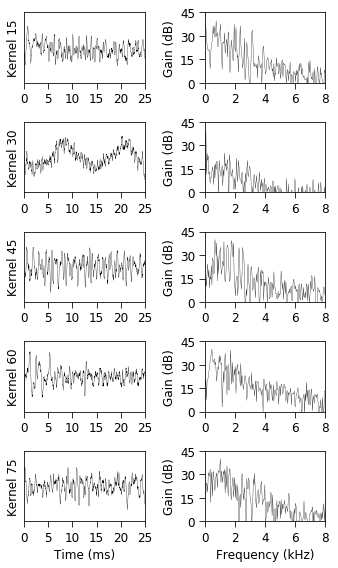

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/example_filter_kernels_arch_0191_cochlearn.pdf


In [64]:
sr = 32e3
kernels = tf_var_value.copy()

t = np.arange(0, kernels.shape[1]) / sr * 1000

np.random.seed(4078)
list_kernel_idx = np.random.randint(low=0, high=kernels.shape[0], size=[5], dtype=int)
list_kernel_idx = np.sort(list_kernel_idx)
list_kernel_idx = [15, 30, 45, 60, 75]
nrows = len(list_kernel_idx)
ncols = 2

fig, ax_arr = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(2.4*ncols, 1.6*nrows))

for r_idx, kernel_idx in enumerate(list_kernel_idx):
    x = kernels[kernel_idx]
    
    fxx, pxx = util_stimuli.power_spectrum(x, sr)
    fxx = fxx / 1000
    pxx = pxx - pxx.max() + 40
    
    mag_spec = 2 * np.square(np.abs(np.fft.rfft(x) / len(x)))
    mag_spec_freqs = np.fft.rfftfreq(len(x), d=1/sr) / 1000
    centroid = np.sum(mag_spec * mag_spec_freqs) / np.sum(mag_spec)
#     ax_arr[r_idx, 1].axvline(x=centroid, color='r')

    ax_arr[r_idx, 0].plot(t, x, color='k', lw=0.3)
    ax_arr[r_idx, 1].plot(fxx, pxx, color='k', lw=0.3)
    kwargs_format_axes0 = {
        'str_xlabel': 'Time (ms)',
        'str_ylabel': 'Kernel {:02d}'.format(kernel_idx),
        'str_title': None,
        'xticks': np.linspace(t[0], t[-1], 6),
        'xticklabels': None,
        'xlimits': [t[0], t[-1]],
        'ylimits': [-0.15, 0.15],
        'yticks': [],
        'yticklabels': [],
    }
    kwargs_format_axes1 = {
        'str_xlabel': 'Frequency (kHz)',
        'str_ylabel': 'Gain (dB)',
        'str_title': None,
        'xticks': [0, 2, 4, 6, 8],
        'xticklabels': None,
        'xlimits': [0, 8],
        'ylimits': [0, 45],
        'yticks': [0, 15, 30, 45],
        'yticklabels': None,
    }
    
    if r_idx < len(list_kernel_idx) - 1:
#         kwargs_format_axes0['xticklabels'] = []
        kwargs_format_axes0['str_xlabel'] = None
#         kwargs_format_axes1['xticklabels'] = []
        kwargs_format_axes1['str_xlabel'] = None
    
    ax_arr[r_idx, 0] = util_figures.format_axes(ax_arr[r_idx, 0], **kwargs_format_axes0)
    ax_arr[r_idx, 1] = util_figures.format_axes(ax_arr[r_idx, 1], **kwargs_format_axes1)
#     ax_arr[r_idx, 1].yaxis.tick_right()
#     ax_arr[r_idx, 1].yaxis.set_label_position('right')
plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'example_filter_kernels_arch_0191_cochlearn.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)
# print(save_fn)


In [ ]:
sr = 32e3

fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=(12, 3),
                       sharex=True,
                       sharey=True)

for model_dict in model_dict_list:    
    model_name = model_dict['model_name']
    kernels = model_dict['vars']['brain_network/coch_conv_0/kernel:0']
    list_pxx = []
    for idx in range(kernels.shape[0]):
        fxx, pxx = util_stimuli.power_spectrum(kernels[idx], sr)
        list_pxx.append(pxx)
#         ax.plot(fxx, pxx, lw=1)
    kernels_pxx = np.stack(list_pxx)
    kernels_pxx_mean = np.mean(kernels_pxx, axis=0)
    kernels_pxx_std = np.std(kernels_pxx, axis=0)
    ax.plot(fxx, kernels_pxx_mean, label=model_name, lw=2)

ax = util_figures.format_axes(ax,
                                str_xlabel='Frequency (Hz)',
                                str_ylabel='Mean power spectrum (dB)',
                                fontsize_labels=12,
                                fontsize_ticks=12,
                                fontweight_labels=None,
                                xscale='linear',
                                yscale='linear',
                                xlimits=None,
                                ylimits=None,
                                xticks=None,
                                yticks=None,
                                xticks_minor=None,
                                yticks_minor=None,
                                xticklabels=None,
                                yticklabels=None,
                                spines_to_hide=[],
                                major_tick_params_kwargs_update={},
                                minor_tick_params_kwargs_update={})
ax.set_title('conv0 kernel mean power spectra', fontsize=12)
ax.legend()
plt.show()


In [ ]:
tf_var = brain_variables[0] # conv0 filter kernels
tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
tf_var_name = tf_var.name

sr = 32e3
print(tf_var_name)

N = tf_var_value.shape[0]

NCOLS = 10
NROWS = int(np.ceil(N / NCOLS))

fig, ax = plt.subplots(nrows=NROWS,
                       ncols=NCOLS,
                       figsize=(2.5*NCOLS, 2.5*NROWS),
                       sharex=True,
                       sharey=False)
ax = ax.flatten()
for idx in range(N):
    x = tf_var_value[idx]
    t = 1e3 * np.arange(0, len(x)) / sr
    ax[idx].plot(t, x, 'k-', lw=0.5)
    (str_xlabel, str_ylabel) = (None, None)
    if idx % NCOLS == 0:
        str_ylabel = 'Pa'
    if idx // NCOLS == NROWS - 1:
        str_xlabel = 'Time (ms)'
    ax[idx] = util_figures.format_axes(
        ax[idx],
        str_xlabel=str_xlabel,
        str_ylabel=str_ylabel,
        fontsize_labels=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        xscale='linear',
        yscale='linear',
        xlimits=None,
        ylimits=None,
        xticks=None,
        yticks=None,
        xticks_minor=None,
        yticks_minor=None,
        xticklabels=None,
        yticklabels=None,
        spines_to_hide=[],
        major_tick_params_kwargs_update={},
        minor_tick_params_kwargs_update={})
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=NROWS,
                       ncols=NCOLS,
                       figsize=(2.5*NCOLS, 2.5*NROWS),
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for idx in range(N):
    x = tf_var_value[idx]
    fxx, pxx = util_stimuli.power_spectrum(x, sr)
    ax[idx].plot(fxx, pxx, 'k-', lw=0.5)
    (str_xlabel, str_ylabel) = (None, None)
    if idx % NCOLS == 0:
        str_ylabel = 'PSD (dB/Hz SPL)'
    if idx // NCOLS == NROWS - 1:
        str_xlabel = 'Frequency (Hz)'
    ax[idx] = util_figures.format_axes(
        ax[idx],
        str_xlabel=str_xlabel,
        str_ylabel=str_ylabel,
        fontsize_labels=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        xscale='linear',
        yscale='linear',
        xlimits=[10, 2e3],
        ylimits=None,
        xticks=None,
        yticks=None,
        xticks_minor=None,
        yticks_minor=None,
        xticklabels=None,
        yticklabels=None,
        spines_to_hide=[],
        major_tick_params_kwargs_update={},
        minor_tick_params_kwargs_update={})
plt.tight_layout()
plt.show()


In [ ]:
model_dir_regex = '/saved_models/arch_search_v02_topN/cochlearn_PND_v08spch_noise_TLAS_snr_neg10pos10/arch_0???'
model_dir_list = glob.glob(model_dir_regex)
model_vars_dict = {}

for model_dir in model_dir_list:
    config_fn = os.path.join(model_dir, 'config.json')
    validation_metrics_fn = os.path.join(model_dir, 'validation_metrics.json')
    with open(config_fn) as f:
        CONFIG = json.load(f)
    ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(validation_metrics_fn,
                                                                 metric_key='f0_label:accuracy',
                                                                 maximize=True,
                                                                 checkpoint_number_key='step')
    ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
    N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
    BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']

    tf.reset_default_graph()
    shape = ITERATOR_PARAMS['feature_parsing_dict'][ITERATOR_PARAMS['feature_signal_path']]['shape']
    batch_subbands = tf.placeholder(tf.float32, shape=[None] + shape)
    if len(batch_subbands.shape) == 2:
        batch_subbands = batch_subbands[:, tf.newaxis, :, tf.newaxis]
    batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess = tf.Session()
    sess.run(init_op)
    brain_var_scope = 'brain_network'
    brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
    restore_model_path = os.path.join(model_dir, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
    brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
    brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
    brain_variables =  brain_globals + brain_locals
    saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
        sess,
        brain_variables,
        model_dir,
        restore_model_path=restore_model_path,
        ckpt_prefix_name=brain_ckpt_prefix_name)
    
    tf_var = brain_variables[0] # conv0 filter kernels
    tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
    tf_var_name = tf_var.name
    model_vars_dict[model_dir] = tf_var_value


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
list_erb = util_stimuli.erbspace(125, 14e3, 100)
ax.plot(list_erb, 'r.-', lw=2, ms=2, label='ERB (not learned)')

list_list_cf = []
for model_dir in model_dir_list:
    kernels = model_vars_dict[model_dir]
    list_cf = []

    for itr_kernel in range(kernels.shape[0]):
        fxx, pxx = util_stimuli.power_spectrum(kernels[itr_kernel], 32e3, dBSPL=False)
        pxx_cumsum = np.cumsum(pxx)
        pxx_cumsum = pxx_cumsum / pxx_cumsum[-1]
        cf = fxx[pxx_cumsum >= 0.5][0]
        list_cf.append(cf)
        
    ax.plot(np.sort(list_cf), '.-', lw=1, ms=1, label=os.path.basename(model_dir))
    list_list_cf.append(np.sort(list_cf))

list_list_cf = np.array(list_list_cf)
yval, yerr = util_figures_psychophysics.combine_subjects(
    list_list_cf, kwargs_bootstrap={})

errorbar_kwargs = {
    'yerr': yerr,
    'fmt': 'none',
    'ecolor': 'k',
    'elinewidth': 0.5,
    'capsize': 1.0,
}
ax.errorbar(np.arange(yval.shape[0]), yval, **errorbar_kwargs)
ax.plot(np.arange(yval.shape[0]), yval, 'k.-', lw=2, ms=2, label='Mean ± SEM')

ax.legend(ncol=2)
ax = util_figures.format_axes(
        ax,
        str_xlabel='Filter index (sorted by CF)',
        str_ylabel='Characteristic frequency (Hz)',
        str_title='Spectral centroids of learned cochlear filters',
        fontsize_labels=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        xscale='linear',
        yscale='log',
        xlimits=None,
        ylimits=None,
        xticks=None,
        yticks=None,
        xticks_minor=None,
        yticks_minor=None,
        xticklabels=None,
        yticklabels=None,
        spines_to_hide=[],
        major_tick_params_kwargs_update={},
        minor_tick_params_kwargs_update={})
plt.show()


[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=5 rather than up=5 for nnresample_poly_filter
[tfnnresample] using down=8 rather than down=8 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 10000.0 Hz for anti-aliasing lowpass filter


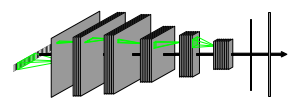

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/schematic_cnn_arch_0191_cochlearn.pdf


In [62]:
# CNN drawing on waveform input

import os
import sys
import json
import copy
import numpy as np
import importlib

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('ibmHearingAid/multi_gpu/')
import functions_brain_network

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures_cnn
importlib.reload(util_figures_cnn)

brain_arch_fn = '/saved_models/arch_search_v02_topN/cochlearn/arch_0191/brain_arch.json'

layer_list = util_figures_cnn.process_cnn_layer_list(brain_arch_fn, input_shape=[1,1,4800,1])
layer_list[1]['shape_activations'] = [100, 1600, 2]

kwargs_polygon_kernel_update = {
    'fc': [0, 1, 0],
}

sr = 32e3
t = np.arange(0, 0.075, 1/sr)
y = np.sin(2 * np.pi * 160 * t) + 0.25 * np.random.randn(t.shape[0])
input_image = np.stack([y], axis=0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1, 1))
ax = util_figures_cnn.draw_cnn_from_layer_list(ax, layer_list,
                                               deg_scale_x=60,
                                               deg_skew_y=30,
                                               scaling_w='log2',
                                               scaling_h='log2',
                                               scaling_n='log2',
                                               range_h=[0.75, np.inf],
                                               input_image=input_image,
                                               kwargs_polygon_kernel_update=kwargs_polygon_kernel_update)

[xb, yb, dxb, dyb] = ax.dataLim.bounds
fig_factor = 6
fig.set_size_inches(dxb/fig_factor, dyb/fig_factor)

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'schematic_cnn_arch_0191_cochlearn.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)
# print(save_fn)
